# Chapter 11 - Melting column models

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.optimize import fsolve
from scipy.special import lambertw, erf
from scipy.integrate import odeint

import warnings 
warnings.filterwarnings('ignore')

## Melting-rate closures

The simplified equations of mass conservation are

$$
\begin{align}
\label{eq:col-compaction-nondim_1}
\por^\permexp(1-\por_0\por)^2 + \velratio\por - \frac{\velratio}{\por_0}F &= 0, \\
w(z) &= W_0\frac{\density\sol}{\density\liq}\frac{F}{\por},\\
\label{eq:meltcol-velocity-solution-W1}
W(z) &= W_0 \frac{1-F}{1-\phi}.
\end{align}
$$

In Python, equation $\eqref{eq:col-compaction-nondim_1}$ is implemented as

In [2]:
def implicit_porosity(f, F, Ql, n):
    return Ql * np.power(f, n)*(1-f)**2 + f - F

The small-porosity Darcy solution for $\permexp=2$ is given by

$$
\begin{align}
    \label{eq:meltcol-porosity-n2}
    \por(z) &= \frac{\velratio}{2}\left(\sqrt{1+\frac{4 F}{\velratio\por_0}} - 1\right), \\
    \label{eq:meltcol-velocity-solution-w}
    w(z) &= \frac{\velratio}{\por_0}\frac{F}{\por},\\
    \label{eq:meltcol-velocity-solution-W}
    W(z) &= 1-F
\end{align}
$$

### Prescribed melting rate

Under the assumption that Darcy drag balances buoyancy of the liquid phase, the melting rate reads

$$
\begin{equation}
  \label{eq:constant-adiabatic-melting}
  \Gamma = \density W_0 \Fmax/z_0.
\end{equation}
$$

The equations and parameters are implemented as:

In [3]:
n = 2
Fmax = 0.2
Q = np.asarray([1.e3, 1.e4])

z = np.logspace(-8., 0., 100)
phi = np.asarray([1. / 2. / qi * (np.sqrt(1. + 4 * z * Fmax * qi)-1) for qi in Q])
w = np.asarray([Fmax*z/phi_i for phi_i in phi])
W = np.asarray([(1.0 - Fmax*z)/(1.0 - phi_i) for phi_i in phi])

imphi = np.asarray([[fsolve(lambda f_: implicit_porosity(f_, Fmax*Z, qi, n), phi_ij)[0]
                    for Z, phi_ij in zip(z, phi_i)] for qi, phi_i in zip(Q, phi)])

Figure 11.1 below plot the solutions of the melting column model with prescribed melting rate $\eqref{eq:constant-adiabatic-melting}$, under the assumption that Darcy drag balances buoyancy of the liquid phase. Black lines show the analytical solution $\eqref{eq:meltcol-porosity-n2}$ and $w(z)/W_0 = F(z)/\phi(z)$. Parameters are $\Fmax=0.2$, $\permexp=2$, and $\fluxpar$ as given in the legend. __(a)__ Degree of melting. __(b)__ Scaled solid upwelling rate. __(c)__ Porosity. Thin grey lines show the numerical solution of the implicit equation $\eqref{eq:col-compaction-nondim_1}$. __(d)__ Liquid upwelling rate scaled with the inflow solid upwelling rate.

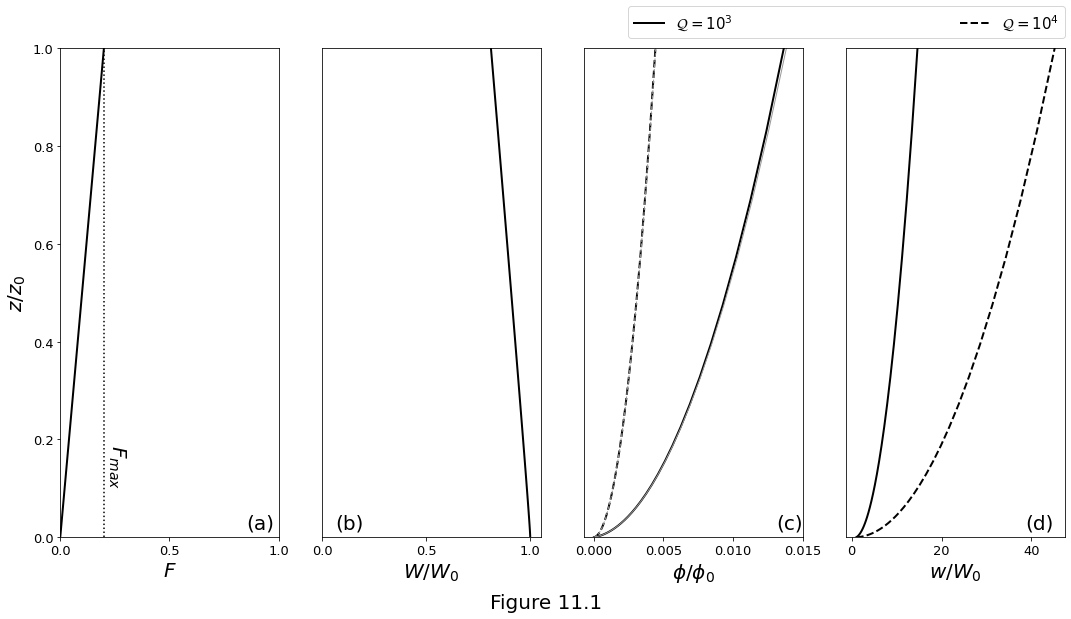

In [4]:
f, ax = plt.subplots(1, 4)
f.set_size_inches(18.0, 9.0)
f.set_facecolor('w')

ax[0].plot(z*Fmax, z, '-k', linewidth=2)
ax[0].plot([Fmax, Fmax], [0., 1.], ':k')
ax[0].set_xlabel(r'$F$', fontsize=20)
ax[0].set_xticks((0.0, 0.5, 1.0))
ax[0].set_xlim(0.0, 1.0)
ax[0].set_ylim(0.0, 1.0)
ax[0].set_ylabel(r'$z/z_0$', fontsize=20)
ax[0].set_yticks(np.arange(0.0, 1.1, 0.2))
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].text(0.26, 0.1, r'$F_{max}$', fontsize=20, verticalalignment='bottom', 
           horizontalalignment='center', rotation=-90.0)
ax[0].text(0.98, 0.01, '(a)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

ax[1].plot(W[0, :], z, '-k', linewidth=2)
ax[1].set_xlabel(r'$W/W_0$', fontsize=20)
ax[1].set_xlim(0.0, 1.05)
ax[1].set_ylim(0.0, 1.0)
ax[1].set_xticks((0.0, 0.5, 1.0))
ax[1].set_yticks(())
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[1].text(0.2, 0.01, '(b)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

p1 = ax[2].plot(phi[0, :], z, '-k', linewidth=2)
p2 = ax[2].plot(phi[1, :], z, '--k', linewidth=2)
ax[2].plot(imphi[0, :], z, '-', linewidth=1, color=[0.6, 0.6, 0.6])
ax[2].plot(imphi[1, :], z, '--', linewidth=1, color=[0.6, 0.6, 0.6])
ax[2].set_xlabel(r'$\phi/\phi_0$', fontsize=20)
ax[2].set_xticks((0.0, 0.005, 0.01, 0.015))
ax[2].set_yticks(())
ax[2].set_ylim(0.0, 1.0)
ax[2].tick_params(axis='both', which='major', labelsize=13)
ax[2].text(0.015,0.01, '(c)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

plt.legend(handles=(p1[0], p2[0]), fontsize=15,
           labels=(r'$\mathcal{Q}=10^3$', r'$\mathcal{Q}=10^4$'),
           bbox_to_anchor=(-1.0, 1.02, 2., .2),  loc='lower left', ncol=2, mode="expand", borderaxespad=0.)

ax[3].plot(w[0, :], z, '-k', linewidth=2)
ax[3].plot(w[1, :], z, '--k', linewidth=2)
ax[3].set_xlabel(r'$w/W_0$', fontsize=20)
ax[3].set_xticks((0.0, 20.0, 40.0))
ax[3].set_yticks(())
ax[3].set_ylim(0.0, 1.0)
ax[3].tick_params(axis='both', which='major', labelsize=13)
ax[3].text(45., 0.01, '(d)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

f.supxlabel("Figure 11.1", fontsize=20)

plt.show()

Figures below plot the solutions of the melting column model with prescribed melting rate $\eqref{eq:constant-adiabatic-melting}$. Parameters as in the Figure above. __(a)__ The scaled porosity from equation $\eqref{eq:meltcol-porosity-n2}$ as a function of column height with logarithmic axes. Narrow, dashed lines show scalings $\por \propto z$ and $\por \propto z^{1/\permexp}$. __(b)__ The _a posteriori_, non-dimensional compaction pressure, computed from the solution for $W(z),\phi(z)$ from $\eqref{eq:meltcol-porosity-n2}$ and $\por w =  W_0F(z)$. Two forms for the augmented compaction viscosity are considered: the black lines represent $\cmpvisc=\por^{-1}$; the gray lines represent $\cmpvisc=-\ln\por$.

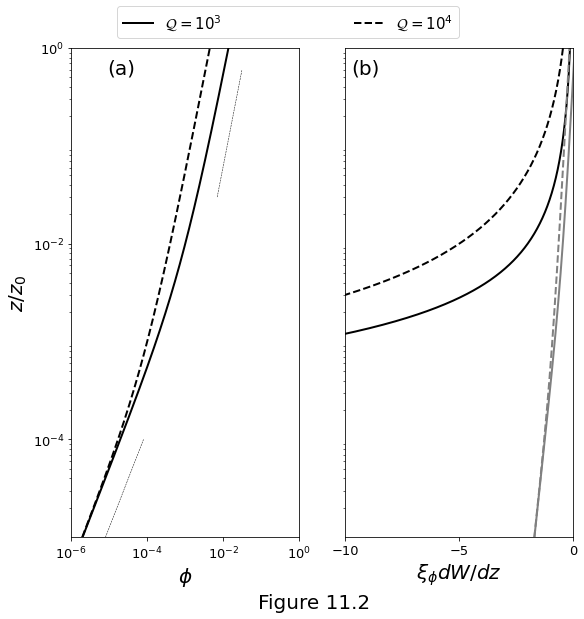

In [5]:
f, ax = plt.subplots(1, 2)
f.set_size_inches(9.0, 9.0)
f.set_facecolor('w')

n = 2
Fmax = 0.2
Q = np.asarray([1e3, 1e4])
zmin = 1e-5

z = np.logspace(np.log10(zmin), 0.0, 1000)
phi = np.asarray([0.5/qi*(np.sqrt(1+4*z*Fmax*qi) - 1.0) for qi in Q])

DP = np.asarray([-Fmax/(phi[0, :]/0.01),
                 -Fmax/(phi[1, :]/0.01),
                 -Fmax*(-np.log(phi[0, :]/0.01)),
                 -Fmax*(-np.log(phi[1, :]/0.01))])

zz = np.asarray([1e-5, 1e-4])
ff = zz * 0.8
zzz = np.asarray([3e-2, 6e-1])
fff = np.power(zzz, 1.0/n)/25.0

p1 = ax[0].loglog(phi[0, :], z, '-k', linewidth=2)
p2 = ax[0].loglog(phi[1, :], z, '--k', linewidth=2)
ax[0].loglog(ff, zz, '--k', linewidth=0.5)
ax[0].loglog(fff, zzz, '--k', linewidth=0.5)
ax[0].set_xlabel(r'$\phi$', fontsize=20)
ax[0].set_xlim((1e-6, 1.0))
ax[0].set_xticks((1e-6, 1e-4, 1e-2, 1.0))
ax[0].set_ylabel(r'$z/z_0$', fontsize=20)
ax[0].set_ylim((1e-5, 1.0))
ax[0].set_yticks((1e-4, 1e-2, 1e0))
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].text(5e-5, 0.5, '(a)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')
plt.legend(handles=(p1[0], p2[0]), fontsize=15, labels=(r'$\mathcal{Q}=10^3$', r'$\mathcal{Q}=10^4$'),
           bbox_to_anchor=(-1.0, 1.02, 1.5, .2),  loc='lower left', ncol=2, mode="expand", borderaxespad=0.)

ax[1].plot(DP[0, :], z, '-k', linewidth=2)
ax[1].plot(DP[1, :], z, '--k', linewidth=2)
ax[1].plot(DP[2, :], z, '-', linewidth=2, color=[0.5, 0.5, 0.5])
ax[1].plot(DP[3, :], z, '--', linewidth=2, color=[0.5, 0.5, 0.5])
ax[1].set_xlabel(r'$\xi_\phi dW/dz$', fontsize=20)
ax[1].set_xlim((-10., 0.0))
ax[1].set_xticks((-10, -5, 0))
ax[1].set_ylim((1e-5, 1.0))
ax[1].set_yscale('log')
ax[1].set_yticks(())
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[1].text(-8.5, 0.5, '(b)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

f.supxlabel("Figure 11.2", fontsize=20)

plt.show()

### Thermodynamically consistent melting rate

In one-dimension and at steady state, the temperature equation can be simplified using the dimensional mass conservation equation

$$
\begin{equation}
  \label{eq:col-energy-temperature}
  \density\heatcapacity W_0 \diff{\temp}{z} = -\left(\latent\Gamma + \density\expansivity W_0 g \temp\right).
\end{equation}
$$

#### One component mantle column

For a one-component mantle, we define the maximum degree of melting as

$$
\begin{equation}
  \label{eq:col-onecomp-Fmax}
  \Fmax^{1c} \equiv \frac{\density g/\clapeyron -  
    \expansivity g\soltemp_0/\heatcapacity}{\latent/\heatcapacity} z_0
\end{equation}
$$

and the melting rate $\Gamma$ is approximated as

$$
\begin{equation}
  \label{eq:col-onecomp-meltrate-Fmax}
  \Gamma \approx \density W_0 \Fmax^{1c}/z_0.
\end{equation}
$$

The table below summarizes the simulation parameters

Quantity | &nbsp; &nbsp; &nbsp; value &nbsp; &nbsp; &nbsp; &nbsp; | unit
---      | :---:   | ---:
$\phi_0$ | 0.01  | ––
$z_0$    | 60    | km  
$\soltemp_0$ | 1650 | K
$\permexp$ |  2                      
$\density$| 3000 | kg/$m^3$
$\heatcapacity$ | 1200 | J/kg/K
$\expansivity$ | $3 \times 10^{-5}$ | $K^{-1}$
$\latent$ | $5 \times 10^{5}$ | J/kg
$\dFdT$ | $1/500$ | $K^{-1}$
$\clapeyron$ | $6.5 \times 10^6$ | Pa/K
$\soltemp_0$ | 1373 | K
$\potemp$ | 1623 | K

In [6]:
z0 = 60e3  # column height, metres
c = 1200.  # heat capacity
alpha = 3e-5  # expansivity
rho = 3000.  # density
g = 10.  # gravity
L = 5e5  # latent heat J/kg
C = 6.5e6  # clapeyron Pa/K
TsP0 = 1100. + 273.  # solidus at P=0
Tsz0 = TsP0 + rho*g*z0/C

n = 2
Q = np.asarray([1e3, 1e4])
z = np.linspace(0., 1., 1000, endpoint=False)
Fmax = g*z0*rho*c/C/L*(1.-alpha*C*Tsz0/rho/c)
T = 1 - rho*g*z0*z/C/Tsz0

phi = np.asarray([0.5/qi * (np.sqrt(1. + 4.*z*Fmax*qi) - 1.0) for qi in Q])

Figure 11.3 below plot the solutions of the one-component melting column model with melting rate $\eqref{eq:col-onecomp-meltrate-Fmax}$ under the assumption that Darcy drag balances buoyancy of the liquid phase. Parameters are given in table above. __(a)__ Temperature. The slope of this curve is $-\rho g/\clapeyron$. __(b)__ Degree of melting with $\Fmax^{1c}$ as given in $\eqref{eq:col-onecomp-Fmax}$. __(c)__ Scaled porosity from $\eqref{eq:meltcol-porosity-n2}$.

[]

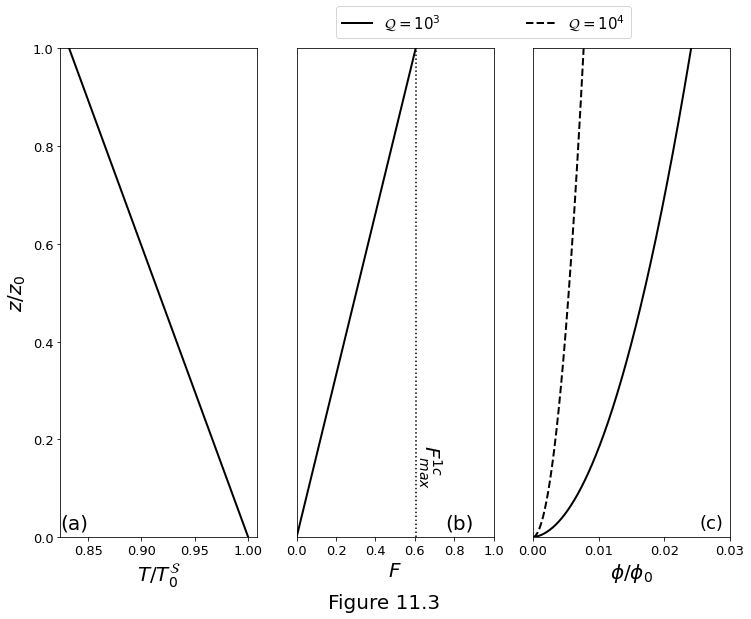

In [7]:
f, ax = plt.subplots(1, 3)
f.set_size_inches(12.0, 9.0)
f.set_facecolor('w')

ax[0].plot(T, z, '-k', linewidth=2)
ax[0].set_xlabel(r'$T/T^\mathcal{S}_0$', fontsize=20)
ax[0].set_ylabel(r'$z/z_0$', fontsize=20)
ax[0].set_ylim(0.0, 1.0)
ax[0].set_yticks(np.arange(0.0, 1.01, 0.2))
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].text(0.85, 0.01, '(a)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

ax[1].plot(Fmax*z, z, '-k', linewidth=2)
ax[1].plot([Fmax, Fmax], [0.0, 1.0], ':k')
ax[1].set_xlabel(r'$F$', fontsize=20)
ax[1].set_xlim(0.0, 1.0)
ax[1].set_ylim(0.0, 1.0)
ax[1].set_yticks(())
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[1].text(Fmax+0.07, 0.1, r'$F_{max}^{1c}$', fontsize=20, verticalalignment='bottom',
           horizontalalignment='center', rotation=-90)
ax[1].text(0.9, 0.01, '(b)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

p1 = ax[2].plot(phi[0, :], z, '-k', linewidth=2)
p2 = ax[2].plot(phi[1, :], z, '--k', linewidth=2)
ax[2].set_xlabel(r'$\phi/\phi_0$', fontsize=20)
ax[2].set_xlim(0.0, 0.03)
ax[2].set_xticks((0.0, 0.01, 0.02, 0.03))
ax[2].set_ylim(0.0, 1.0)
ax[2].set_yticks(())
ax[2].tick_params(axis='both', which='major', labelsize=13)
ax[2].text(0.029, 0.01, '(c)', fontsize=18, verticalalignment='bottom', horizontalalignment='right')

plt.legend(handles=(p1[0], p2[0]), fontsize=15, labels=(r'$\mathcal{Q}=10^3$', r'$\mathcal{Q}=10^4$'),
           bbox_to_anchor=(-1.0, 1.02, 1.5, .2),  loc='lower left', ncol=2, mode="expand", borderaxespad=0.)

f.supxlabel("Figure 11.3", fontsize=20)

plt.plot()

#### Two-component mantle column

In this case, the melting rate $\Gamma$ reads

$$
\begin{equation}
  \label{eq:col-twocomp-Gamma}
  \Gamma \approx \density W_0 \frac{\density g\clapeyron^{-1} - \expansivity
  g \soltemp_0/\heatcapacity}{\solslope\Delta\con + \latent/\heatcapacity},
\end{equation}
$$

The simulation parameters are summarized below:

Quantity | &nbsp; &nbsp; &nbsp; value &nbsp; &nbsp; &nbsp; &nbsp; | unit
---      | :---:   | ---:
$\solslope\Delta\con$ | 700 | $K$
$\phi_0$ | 0.01  | ––
$z_0$ | 60 | km
$\soltemp_0$ | 1650 | K
$\permexp$ |  2 | ––
$\density$| 3000 | kg/$m^3$
$\heatcapacity$ | 1200 | J/kg/K
$\expansivity$ | $3 \times 10^{-5}$ | $K^{-1}$
$\latent$ | $5 \times 10^{5}$ | J/kg
$\dFdT$ | $1/500$ | $K^{-1}$
$\clapeyron$ | $6.5 \times 10^6$ | Pa/K
$\soltemp_0$ | 1373 | K
$\potemp$ | 1623 | K

In [8]:
z0 = 60e3  # column height, metres
c = 1200.  # heat capacity
alpha = 3e-5  # expansivity
rho = 3000.  # density
g = 10.  # gravity
L = 5e5  # latent heat J/kg
C = 6.5e6  # clapeyron Pa/K
Mdc = 700.  # sol slope times Delta c, K
TsP0 = 1100. + 273.  # solidus at P=0
Tsz0 = TsP0 + rho*g*z0/C

Fmax = rho*g*z0/L*(c/C - alpha/rho*Tsz0)/(1+c*Mdc/L)

n = 2
Q = np.asarray([1e3, 1e4])

z = np.linspace(0,1,1000)
F = Fmax * z
W = 1. - F
T = 1. - rho*g/C*z0/Tsz0*z + Mdc*F/Tsz0
Tcc = 1. - rho*g/C*z0/Tsz0*z

phi = np.asarray([0.5/qi * (np.sqrt(1.0 + 4.0*z*Fmax*qi) - 1.0) for qi in Q])
Cb = np.asarray([F - phii for phii in phi])

Figure 11.4 below plot the solutions of the two-component, batch-melting column model with melting rate $\eqref{eq:col-twocomp-Gamma}$ under the assumption that Darcy drag balances buoyancy of the liquid phase. Parameters are given in table above. __(a)__ Temperature. Dotted line shows the Clausius-Clapeyron slope $-\rho g/\clapeyron$. __(b)__ Scaled porosity. __(c)__ Scaled bulk composition. The degree of melting $F$ is not shown; it increases linearly to $\Fmax^{2c} = 0.225$, as discussed in the main text.

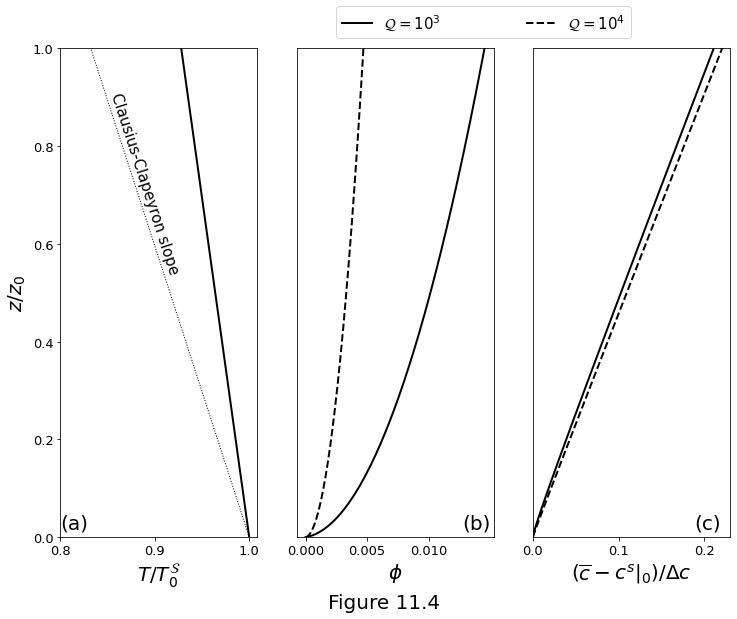

In [9]:
f, ax = plt.subplots(1, 3)
f.set_size_inches(12.0, 9.0)
f.set_facecolor('w')

ax[0].plot(T, z, '-k', linewidth=2)
ax[0].plot(Tcc, z,':k', linewidth=1)
ax[0].set_xlabel(r'$T/T^\mathcal{S}_0$', fontsize=20)
ax[0].set_xticks((0.8, 0.9, 1.0))
ax[0].set_ylabel(r'$z/z_0$', fontsize=20)
ax[0].set_yticks(np.arange(0.0, 1.01, 0.2))
ax[0].set_ylim(0.0, 1.0)
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].text(0.85, 0.54, r'Clausius-Clapeyron slope', fontsize=15, horizontalalignment='left', rotation=-72)
ax[0].text(0.83, 0.01, '(a)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

p1 = ax[1].plot(phi[0, :], z, '-k', linewidth=2)
p2 = ax[1].plot(phi[1, :], z, '--k', linewidth=2)
ax[1].set_xlabel(r'$\phi$', fontsize=20)
ax[1].set_xticks((0, 0.005, 0.01))
ax[1].set_yticks(())
ax[1].set_ylim(0.0, 1.0)
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[1].text(0.015, 0.01, '(b)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

plt.legend(handles=(p1[0], p2[0]), fontsize=15, labels=(r'$\mathcal{Q}=10^3$', r'$\mathcal{Q}=10^4$'),
           bbox_to_anchor=(-1.0, 1.02, 1.5, .2),  loc='lower left', ncol=2, mode="expand", borderaxespad=0.)

ax[2].plot(Cb[0, :], z, '-k', linewidth=2)
ax[2].plot(Cb[1, :], z, '--k', linewidth=2)
ax[2].set_xlabel(r'$(\overline{c}-c^{s}\vert_0)/\Delta c$', fontsize=20)
ax[2].set_xlim(0.0, 0.23)
ax[2].set_xticks((0.0, 0.1, 0.2))
ax[2].set_ylim(0.0, 1.0)
ax[2].set_yticks(())
ax[2].tick_params(axis='both', which='major', labelsize=13)
ax[2].text(0.22, 0.01, '(c)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

f.supxlabel("Figure 11.4", fontsize=20)

plt.show()

#### Two-component column with an incompatible component
    
The normalized volatile concentration in the solid is given by

$$
\begin{equation}
  \label{eq:col-twocomp-vol-nonlinear-cs-solution}
  \con\sol(z) = \frac{1}{2}\left[\coninflow - \frac{A_1}{\coninflow} +
    A_2z + \sqrt{4A_1 + \left(A_2z + \coninflow - 
        \frac{A_1}{\coninflow}\right)^2}\right].
\end{equation}
$$

The degree of melting as a function of the height is given by

$$
\begin{equation}
  \label{eq:col-twocomp-vol-nonlinear-F-solution}
   F = \frac{\heatcapacity}{\latent}\left[\left(\frac{\density g}
   {\clapeyron} - \frac{\expansivity g \soltemp_0}{\heatcapacity}\right)z + \solslope\left(\coninflow - \con\sol\right)\right].
\end{equation}
$$

Temperature as a function of height in the melting column is given by

$$
\begin{equation}
\label{eq:col-twocomp-pd-solidus}
\soltemp = \soltemp_\text{ref} + (\pres-\pres_\text{ref})/\clapeyron  +
           \solslope\left(\equi\con\sol - \equi\con\sol_{\text{ref}}\right)
\end{equation}
$$

The simulation parameters are summarized below:

Quantity | &nbsp; &nbsp; &nbsp; value &nbsp; &nbsp; &nbsp; &nbsp; | unit
---      | :---:   | ---:
$\solslope$ | -4 | K/ppm
$\coninflow{}$ | 100 | ppm
$\por_0$ | 0.01 | –– 
$\velratio$ | 0.01 | ––
$\phi_0$ | 0.01  | ––
$z_0$    | 60    | km  
$\soltemp_0$ | 1650 | K
$\permexp$ |  2 | ––              
$\density$| 3000 | kg/$m^3$
$\heatcapacity$ | 1200 | J/kg/K
$\expansivity$ | $3 \times 10^{-5}$ | $K^{-1}$
$\latent$ | $5 \times 10^{5}$ | J/kg
$\dFdT$ | $1/500$ | $K^{-1}$
$\clapeyron$ | $6.5 \times 10^6$ | Pa/K
$\soltemp_0$ | 1373 | K
$\potemp$ | 1623 | K

In [10]:
D = 0.01  # distribution coefficient
c = 1200.  # heat capacity J/kg/K
alpha = 3e-5  # expansivity /K
rho = 3000.  # density
g = 10.  # gravity
L = 5e5  # latent heat J/kg
C = 6.5e6  # clapeyron Pa/K
M = -4.  # solidus slope, K per ppm volatile
c0 = 100.  # volatile concentration, ppm
TsP0 = 1100. + 273.  # solidus at P=0
Ts0 = 1300. + 273.  # mantle temperature
Q = 1e4           # flux parameter
n = 2               # permeability exponent

Mc0 = M*c0
z0 = (Ts0 - TsP0 - Mc0)/(rho*g/C)

z = np.linspace(0.0, z0, 300)
Tcc = Ts0 - rho*g/C*z

A1 = L*c0/c/M/(1.-1./D)
A2 = -g/M*(alpha*Ts0/c - rho/C)
cs = 0.5*(c0 - A1/c0 + A2*z + np.sqrt(4.*A1 + (A2*z + c0 - A1/c0)**2))
F = c/L*(rho*g*z/C + M*(c0-cs) - alpha*g*Ts0*z/c)
T = Ts0 - rho*g*z/C + M*(cs-c0)
phi = 1./2./Q*(np.sqrt(1.0 + 4.*F*Q) - 1.0)

a = (1/D - 1)*c*M/L
beta = -g*rho/(M*C) + alpha*g*Ts0/(c*M)

cf =  -lambertw((-c0)*a*np.exp((-c0)*a)*np.exp(a*beta*z))/a  # Lambert W approximation
Ff = c/L*(rho*g*z/C + M*(c0-cf) - alpha*g*Ts0*z/c)
Tf = Ts0 - rho*g*z/C + M*(cf-c0)
phif = 1./Q/2.*(np.sqrt(1.0 + 4.0*Ff*Q) - 1.0)

Figure 11.5 below plot a solution of the two-component melting column model with a volatile component. Parameters given in the Table above. The onset of melting is marked by a red dot in each panel. The bottom of the column $z=0$ corresponds to a depth of 130 km and $\soltemp_0=1300^\circ$ C. The solid line represents the solution developed for equilibrium between solid and liquid phases (batch melting); the dashed line represents fractional melting (see main text for details). __(a)__ The normalised volatile concentration in the solid from equation $\eqref{eq:col-twocomp-vol-nonlinear-cs-solution}$. __(b)__ Degree of melting as a function of height, computed according to equation $\eqref{eq:col-twocomp-vol-nonlinear-F-solution}$. __(c)__ Temperature as a function of height in the melting column, obtained from the solidus relation $\eqref{eq:col-twocomp-pd-solidus}$. __(d)__ Porosity computed according to the approximate Darcy solution $\eqref{eq:meltcol-porosity-n2}$ for $\permexp=2$.

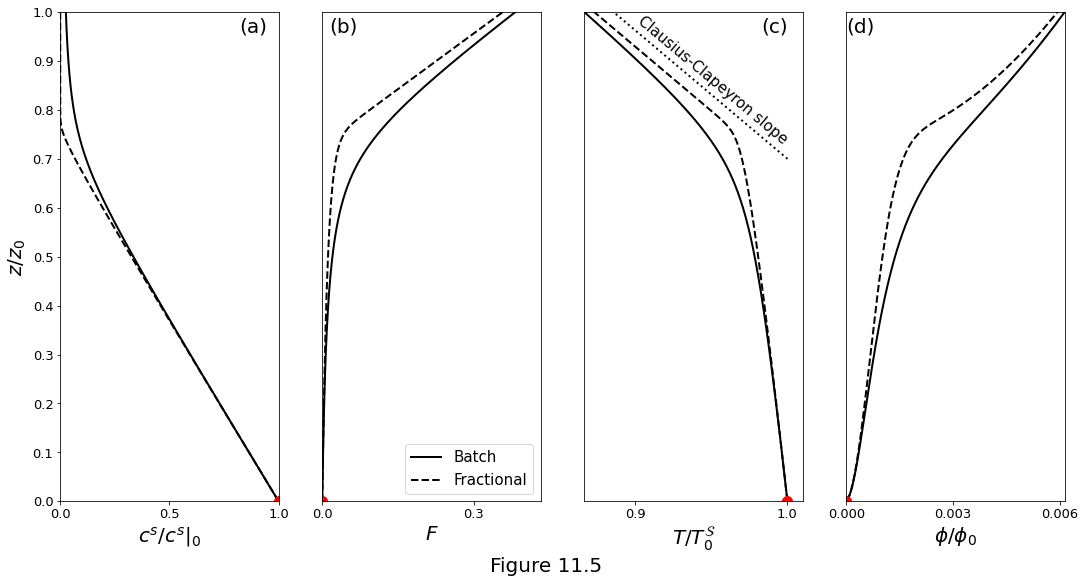

In [11]:
f, ax = plt.subplots(1, 4)
f.set_size_inches(18.0, 9.0)
f.set_facecolor('w')

ax[0].plot(cs/c0, z/z0, '-k', linewidth=2)
ax[0].plot(cf/c0, z/z0, '--k', linewidth=2)
ax[0].plot(1., 0., 'or', markersize=10)
ax[0].set_xlabel(r'$c^s/c^s\vert_0$', fontsize=20)
ax[0].set_ylabel(r'$z/z_0$', fontsize=20)
ax[0].set_xlim(0.0, 1.0)
ax[0].set_xticks((0.0, 0.5, 1.0))
ax[0].set_ylim(0.0, 1.0)
ax[0].set_yticks(np.arange(0.0, 1.01, 0.1))
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].text(0.95, 0.95, '(a)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

p1, = ax[1].plot(F, z/z0, '-k', linewidth=2, label='Batch')
p2, = ax[1].plot(Ff, z/z0, '--k', linewidth=2, label='Fractional')
ax[1].plot(0.0, 0.0, 'or', markersize=10)
ax[1].set_xlim(0.0, np.amax(F)+0.05)
ax[1].set_xticks((0.0, 0.3))
ax[1].set_xlabel(r'$F$', fontsize=20)
ax[1].set_ylim(0.0, 1.0)
ax[1].set_yticks(())
ax[1].legend(handles=[p1, p2], fontsize=15, loc='lower right')
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[1].text(0.07, 0.95, '(b)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

ax[2].plot(T/Ts0, z/z0, '-k', linewidth=2)
ax[2].plot(Tf/Ts0,z/z0,'--k', linewidth=2)
ax[2].plot(1.0, 0.0, 'or', markersize=10)
ax[2].plot(Tcc/Ts0, z/z0 + 0.70, ':k', linewidth=2)
ax[2].set_xlabel(r'$T/T^\mathcal{S}_0$', fontsize=20)
ax[2].set_xlim(np.amin(T/Ts0), 1.01)
ax[2].set_xticks((0.9, 1.0))
ax[2].set_ylim(0.0, 1.0)
ax[2].set_yticks(())
ax[2].tick_params(axis='both', which='major', labelsize=13)
ax[2].text(0.90, 0.73, r'Clausius-Clapeyron slope', fontsize=15, horizontalalignment='left', rotation=-40)
ax[2].text(1.0, 0.95, '(c)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

ax[3].plot(phi, z/z0, '-k', linewidth=2)
ax[3].plot(phif, z/z0, '--k', linewidth=2)
ax[3].plot(0.0, 0.0, 'or', markersize=10)
ax[3].set_xlim(0.0, np.max(phi))
ax[3].set_xlabel(r'$\phi/\phi_0$', fontsize=20)
ax[3].set_xticks((0.0, 3.e-3, 6.e-3))
ax[3].set_ylim(0.0, 1.0)
ax[3].set_yticks(())
ax[3].tick_params(axis='both', which='major', labelsize=13)
ax[3].text(0.8e-3, 0.950, '(d)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

f.supxlabel("Figure 11.5", fontsize=20)

plt.show()

## The visco-gravitational boundary layer

The solid upwelling rate is given by 

$$
\begin{equation}
  \label{eq:col-cmp-boundary-solidvel}
  W \sim 1 + \frac{\Fmax \cmppres_b}{2\por_0}z^2,
\end{equation}
$$

The dimensionless, time-dependent governing equations are

$$
\begin{align}
    \label{eq:tdcol-mechanics-compaction-nd}
    \frac{\velratio}{\por_0}(1-W) &= \por^\permexp
    \left[1 - \delta^2\frac{\velratio}{\por_0} \pdiff{}{z}\frac{1}{\por}\pdiff{W}{z}\right],\\
    \label{eq:tdcol-mechanics-porosity-nd}
    \pdiff{\por}{t} + W\diff{\por}{z} &= \frac{1}{\por_0}
    \left(\Fmax + \pdiff{W}{z}\right).
\end{align}
$$

The dimensionless compaction pressure is defined as 

$$
\begin{equation}
  \label{eq:tdcol-compac-pres}
  \cmppres = \bulkvisc\infd W/\infd z
\end{equation}
$$

Table below summarizes the simulation parameters

Quantity | value &nbsp;  &nbsp; 
--- | ---
$\cmplength$ | $0.1$
$\velratio$ | $0.01$
$\por_0$ | $0.01$
$\permexp$ | 2 
$\Fmax$ | 0.225
$z_b$ | $z_0/100$
$\cmpvisc$ | $\por^{-1}$

In [12]:
def AssembleMatrix_W(aw, dz, phi, n, d0):
    zh = 1./(0.5*(phi[0:-1] + phi[1:]))  # bulk viscosity
    b = np.power(phi[1:-1], n)
    aw.data[0] = np.concatenate((b*zh[0:-1], -1.0, 0.0), axis=None)
    aw.data[1] = np.concatenate((1.0, -(b*(zh[0:-1]+zh[1:]) + dz*dz/d0/d0), 1.0), axis=None)
    aw.data[2] = np.concatenate((0.0, 0.0, b*zh[1:]), axis=None)


def AssembleRHS_W(dz, phi, w, d0, Q, n, F0):
    return np.concatenate((w[0], dz*dz/d0/d0*(Q*(phi[1:-1] ** n) - 1), -F0*dz), axis=None)


def AssembleMatrix_phi(Ap, W, dt, dz):
    dtzW = 0.5*dt/dz*W[1:]
    Ap.data[0] = np.concatenate((-dtzW, 0.0), axis=None)
    Ap.data[1] = np.concatenate((1.0, dtzW + 1.0), axis=None)


def AssembleRHS_phi(z, phi, W, dz, F0, dt):
    cmp = np.gradient(W, z)
    cmp_F0 = np.concatenate((cmp[1:-1], -F0), axis=None)
    phidot = -W[1:] * (phi[1:]-phi[0:-1])/dz/2. + (F0 + cmp_F0)
    return np.concatenate((phi[0], dt * phidot + phi[1:]), axis=None)


def MeltingColNumerical(Q=1.e4,  # flux parameter
                        d0=0.1,  # cmplength/colheight
                        F0=0.22, # max degree melting
                        n=2):    # perm exponent

    # domain is four times the estimated boundary layer thickness
    zb = d0 / np.sqrt(Q)
    z = np.linspace(0.0, 4. * zb, 5000)
    dz = z[1] - z[0]
    phi_t0 = np.power(F0/Q*z, 1./n)  # Darcy solution
    W_t0 = 1 - F0 * z  # Darcy solution

    # P0 = - f0 * zb / d0 ** 2 / e0 - F0 * (1 - F0 * zb) / np.power(f0 / e0 * F0 * zb, 1./n)
    # zd = np.linspace(0.0, zb, 10000)
    # phid = F0 / f0 * zd
    # Wd = 1 + F0 * P0 / 2 / f0 * zd ** 2
    # Pd = f0 / (d0 ** 2) / e0 * zd + P0

    # allocate matrices and solution vectors
    N = len(z)
    AW = sp.diags([-1.0, 1.0, 2.0], [-1, 0, 1], shape=(N, N))
    Ap = sp.diags([-1.0, 1.0], [-1, 0], shape=(N, N))
    phi = phi_t0
    W = W_t0

    dt = 0.5 * dz
    tol = 1e-2
    del_ = 1.0

    while del_ > tol:
        phio = phi
        AssembleMatrix_W(AW, dz, 0.5 * (phio + phi), n, d0)
        R = AssembleRHS_W(dz, 0.5 * (phio + phi), W, d0, Q, n, F0)
        W = spsolve(AW.tocsr(), R)  # compaction equation

        AssembleMatrix_phi(Ap, W, dt, dz)
        R = AssembleRHS_phi(z, phio, W, dz, F0, dt)
        phi = spsolve(Ap.tocsr(), R)  # porosity evolution

        # if change of solution is smaller than tolerance, break
        del_ = np.linalg.norm(phi - phio, 2) / dt / np.linalg.norm(phi, 2)  # change of solution

    return z, W, phi, np.gradient(W, z) / phi

In [13]:
delta = 0.1
Q = 1e4
Fmax = 0.22

zb = delta / np.sqrt(Q)
P0 = -2.0 / zb

Z = np.linspace(0.0, 2.0, 1000)  # this is z/zb;

S_z, S_W, S_phi, S_P = MeltingColNumerical(Q, delta, Fmax, 2)

In [14]:
Pbl = -np.sqrt(Q)/delta*(2.0 - Z)
Pbl[Z > 1.5] = np.nan
P   = -1.0/(zb*Z)

V = Fmax*Z*zb - Fmax*zb*np.sqrt(np.pi/2.0)*np.exp(0.5*(Z-2.0)**2) * (erf(np.sqrt(2.0)) + erf(np.sqrt(2.0) * 0.5*(Z-2.0)))
V[Z > 1.5] = np.nan
Wbl = 1 - V
Wbl[Z > 1.5] = np.nan
W   = 1.0 - Fmax*(zb*Z)

phibl = Fmax*zb*Z - V
phi = 1.0/2.0/Q*(np.sqrt(1.0 + 4.0*zb*Z*Fmax*Q) - 1.0)

Figure 11.6 below plot the numerical, Darcy, and boundary layer solutions to the one-dimensional melting column with constant decompressional melting productivity. The numerical solution of the system $\eqref{eq:tdcol-mechanics-compaction-nd}$-$\eqref{eq:tdcol-mechanics-porosity-nd}$ is discretised by finite differences and run to steady state.  The domain is limited to $0\le z \le 2z_b$. Non-dimensional parameters used to compute these solutions are $\cmplength=0.1$, $\fluxpar=10^4$, $\permexp=2$ and $\Fmax=0.22$. For these parameters, $z_b = z_0/100$. The non-dimensional augmented compaction viscosity is $\cmpvisc = \por^{-1}$. __(a)__ Solid upwelling rate. __(b)__ Compaction pressure non-dimensionalised by $\cmppres_0 = \xi_0W_0/z_0$. __(c)__ Porosity.

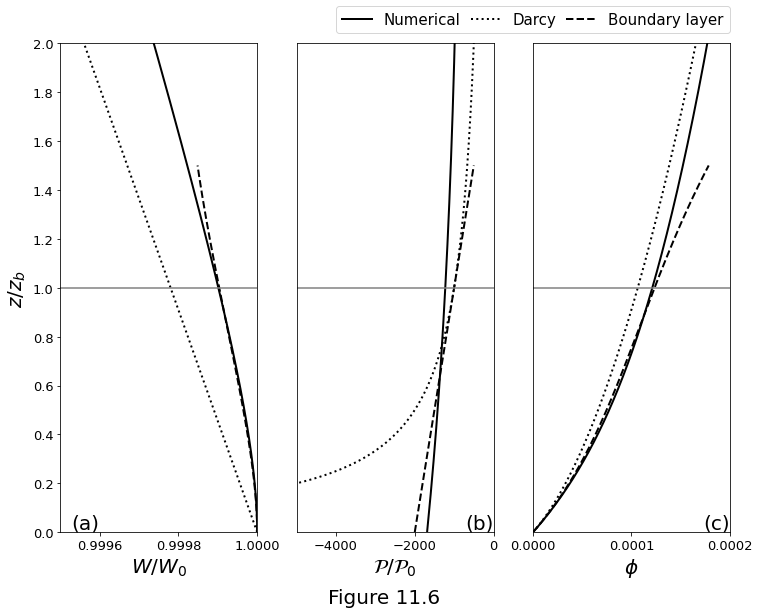

In [15]:
f, ax = plt.subplots(1, 3)
f.set_size_inches(12.0, 9.0)
f.set_facecolor('w')

ax[0].plot(W, Z, ':k', Wbl, Z, '--k', S_W, S_z/zb,'-k', linewidth=2)
ax[0].plot([0.0, 2], [1.0, 1.0], '-', color=[0.5, 0.5, 0.5])
ax[0].set_xlim(0.9995, 1.0)
ax[0].set_xticks((0.9996, 0.9998, 1.0))
ax[0].set_ylim(0.0, 2.0)
ax[0].set_yticks(np.arange(0.0, 2.1, 0.2))
ax[0].set_xlabel(r'$W/W_0$', fontsize=20)
ax[0].set_ylabel(r'$z/z_b$', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].text(0.9996, 0.0, '(a)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

p0, = ax[1].plot(S_P, S_z/zb, '-k', linewidth=2)
p1, = ax[1].plot(P, Z, ':k', linewidth=2)
p2, = ax[1].plot(Pbl, Z, '--k', linewidth=2)
ax[1].plot([-5000.0, 0.0], [1.0, 1.0], '-', color=[0.5, 0.5, 0.5])
ax[1].set_xlim(-5000.0, 0.0)
ax[1].set_xticks((-4000, -2000, 0))
ax[1].set_ylim(0.0, 2.0)
ax[1].set_yticks(())
ax[1].set_xlabel(r'$\mathcal{P}/\mathcal{P}_0$', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[1].text(-5.4, 0.0, '(b)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

plt.legend(handles=[p0, p1, p2], labels=['Numerical', 'Darcy', 'Boundary layer'], fontsize=15,
           bbox_to_anchor=(-1.0, 1.02, 2.0, .2),  loc='lower left', ncol=3, mode="expand", borderaxespad=0.)

ax[2].plot(phi, Z, ':k', phibl, Z, '--k', S_phi, S_z/zb, '-k', linewidth=2)
ax[2].plot([1e-10, 2.0*np.max(S_phi)], [1.0, 1.0], '-', color=[0.5, 0.5, 0.5])
ax[2].set_xlim(0.0, 2e-4)
ax[2].set_xticks((0.0, 1e-4, 2e-4))
ax[2].set_ylim(0.0, 2.0)
ax[2].set_yticks(())
ax[2].set_xlabel(r'$\phi$', fontsize=20)
ax[2].tick_params(axis='both', which='major', labelsize=13)
ax[2].text(2e-4, 1.9e-4, '(c)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

f.supxlabel("Figure 11.6", fontsize=20)

plt.show()

## The decompaction boundary layer

The porosity profile is given by

$$
\begin{equation}
  \label{eq:decmp_porosity}
  \frac{\por}{\por_0} =
  \left[\frac{1-G(z/\freezelength)}{1-R^2G''(z/\freezelength)}\right]^{1/n},
\end{equation}
$$

where $R = \cmplength_0/\freezelength$ is the ratio of the compaction length to the length-scale over which freezing occurs.

The shape function $G(\zeta)$ and its derivatives that can be used to evaluate equation $\eqref{eq:decmp_porosity}$ are defined as

$$
\begin{align}
    \label{eq:shape_function_tanh-G}
    G(\zeta) &= \frac{1}{\ln 2}\left[\zeta + \ln(\cosh\zeta)\right]+1,\\
    \label{eq:shape_function_tanh-Gp}
    G'(\zeta) &= \frac{1}{\ln 2}(1 + \tanh \zeta),\\
    \label{eq:shape_function_tanh-Gpp}
    G''(\zeta) &= \frac{1}{\ln 2}\text{sech}^2\zeta.
\end{align}
$$

The normalised liquid upwelling speed is derived from 

$$
\begin{equation}
  \label{eq:decmp_intro_G}
  \por w \equiv q_\infty\left[1 - G(z/\freezelength)\right],
\end{equation}
$$

where $\freezelength$ is a length-scale over which freezing occurs.

The normalised solid upwelling speed $W(z)/W_0$ is given by

$$
\begin{equation}
  \label{eq:decomp_col_solid_vel}
  \frac{W}{W_0} = 1 - \frac{q_\infty}{W_0}\left[1-G(z/\freezelength)\right].
\end{equation}
$$

In [16]:
R2 = np.asarray([0.0, 0.3, 0.6, 0.69])
fovr = 0.01/np.logspace(-2.0, -1.0, 3)
n = 3

zeta = np.linspace(-4.0, 0.0, 1000)
A = 1.5
G   = (zeta + np.log(2) + np.log(np.cosh(zeta)))/np.log(2)
Gp  = (1 + np.tanh(zeta))/np.log(2)
Gpp = 1./(np.cosh(zeta)**2 * np.log(2))
Phi = np.asarray([np.power((1-G)/(1-R2i*Gpp), 1./n) for R2i in R2])
w = np.asarray([(1-G)/Phii for Phii in Phi])
W = np.asarray([1 - fovri*(1-G) for fovri in fovr])

Figure 11.7 below plot the decompaction column. __(a)__ Quantities $G$, $G'$ and $G''$ as given by equations $\eqref{eq:shape_function_tanh-G}$, $\eqref{eq:shape_function_tanh-Gp}$ and $\eqref{eq:shape_function_tanh-Gpp}$, respectively. __(b)__ The normalised porosity computed with equation $\eqref{eq:decmp_porosity}$ for various values of $R=\cmplength_0/\freezelength$. __(c)__ Normalised liquid upwelling speed for various values of $R$. __(d)__ Normalised solid upwelling speed, equation $\eqref{eq:decomp_col_solid_vel}$, for various flux ratios $q_\infty/W_0$.

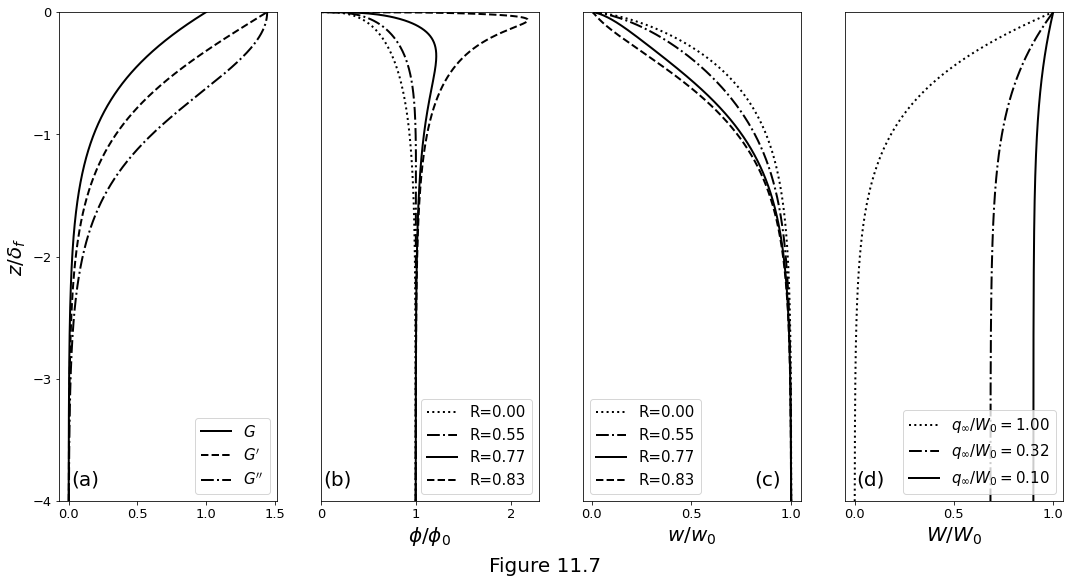

In [17]:
f, ax = plt.subplots(1, 4)
f.set_size_inches(18.0, 9.0)
f.set_facecolor('w')

ax[0].plot(G, zeta, '-k', linewidth=2, label=r'$G$')
ax[0].plot(Gp, zeta, '--k', linewidth=2, label=r'$G^\prime$')
ax[0].plot(Gpp, zeta, '-.k', linewidth=2, label=r'$G^{\prime\prime}$')
ax[0].set_ylim(-4.0, 0.0)
ax[0].set_ylabel(r'$z/\delta_f$', fontsize=20)
ax[0].set_xticks((0.0, 0.5, 1.0, 1.5))
ax[0].set_yticks((-4, -3, -2, -1, 0))
ax[0].legend(loc='lower right', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].text(0.22, -3.9, '(a)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')
                    
for Phii, pltstyi, R2i in zip(Phi, {':k','-.k','--k','-k'}, np.sqrt(R2)):
    ax[1].plot(Phii, zeta, pltstyi, linewidth=2, 
               label="R={0:.2f}".format(R2i))
ax[1].set_xlim(0.0, 2.3)
ax[1].set_ylim(-4.0, 0.0)
ax[1].set_xticks((0.0, 1.0, 2.0))
ax[1].set_yticks(())
ax[1].set_xlabel(r'$\phi/\phi_0$', fontsize=20)
ax[1].legend(loc='lower right', fontsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[1].text(0.32, -3.9, '(b)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

for wi, pltstyi, R2i in zip(w, {':k','-.k','--k','-k'}, np.sqrt(R2)):
    ax[2].plot(wi, zeta, pltstyi, linewidth=2, label="R={0:.2f}".format(R2i))
ax[2].set_xlabel(r'$w/w_0$', fontsize=20)
ax[2].set_ylim(-4.0, 0.0)
ax[2].set_xticks((0.0, 0.5, 1.0))
ax[2].set_yticks(())
ax[2].legend(loc='lower left', fontsize=15)
ax[2].tick_params(axis='both', which='major', labelsize=13)
ax[2].text(0.95, -3.9, '(c)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

for Wi, pltstyi, fovri in zip(W, {':k','-.k','--k','-k'}, fovr):
    ax[3].plot(Wi, zeta, pltstyi, linewidth=2, label="$q_\infty/W_0={0:.2f}$".format(fovri))
ax[3].set_yticks(())
ax[3].set_ylim(-4.0, 0.0)
ax[3].set_xticks((0.0, 0.5, 1.0))
ax[3].set_xlabel('$W/W_0$', fontsize=20)
ax[3].legend(loc='lower right', fontsize=15)
ax[3].tick_params(axis='both', which='major', labelsize=13)
ax[3].text(0.15, -3.9, '(d)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

f.supxlabel("Figure 11.7", fontsize=20)

plt.show()

## Isotopic decay-chain disequilibria in a melting column

### Constant transport rates

The low transport regime is given by

$$
\begin{equation}
  \label{eq:const-coltop-slow-approx}
  \inact\liq_2\vert_1 \sim \frac{\pormax + \dico_1}{\pormax + \dico_2},\;\;\;\;\;\;\;\;\;\;\;\;
  \inact\liq_3\vert_1 \sim \frac{\pormax + \dico_1}{\pormax + \dico_3},
\end{equation}
$$

while the fast transport regime is given by

$$
\begin{equation}
  \label{eq:const-coltop-fast-transport}
  \inact\liq_2\vert_1 \sim 1 +
  \frac{\deco_2z_0}{W_0\Fmax}\left(\dico_{1} - \dico_2\right),\;\;\;\;\;\;\;\;\;\;\;\;
  \inact\liq_3\vert_1 \sim 1 +
  \frac{\deco_3z_0}{W_0\Fmax}\left(\dico_{2} - \dico_3\right).  
\end{equation}
$$

In [18]:
fmax = np.logspace(-5.0, 0.0, 1000)
D = np.asarray([1e-2, 0.5e-2, 0.5e-3])
al2s = (fmax+D[0])/(fmax+D[1])
al3s = (fmax+D[0])/(fmax+D[2])

z0 = 60e3  # meters
W0 = np.logspace(-2.0, 2.0, 1000)*1e-2  # meters/year
Fmax = 0.2
lmbda = np.asarray([1.0, 1e-5, 1e-4])  # per year

al2f = 1.0 + lmbda[1]*z0/W0/Fmax*(D[0]-D[1])
al3f = 1 + lmbda[2]*z0/W0/Fmax*(D[1]-D[2])

Figure 11.8 below plots the ingrowth factors at the top of the column, with the following parameters

Parameters | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; value &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | unit
--- | --- | ---
$\Fmax$ | 0.2 | ––
$z_0$ | 60 | km
$D_1$ | $10^{-2}$ | ––
$D_2$ | $5\times10^{-3}$ | ––
$D_3$ | $5\times10^{-4}$ | ––
$\deco_2$ | $10^{-5}$ | yr$^{-1}$
$\deco_3$ | $10^{-4}$ | yr$^{-1}$

__(a)__ Slow transport regime, computed with equations $\eqref{eq:const-coltop-slow-approx}$. 

__(b)__ Fast transport regime, computed with equations $\eqref{eq:const-coltop-fast-transport}$.

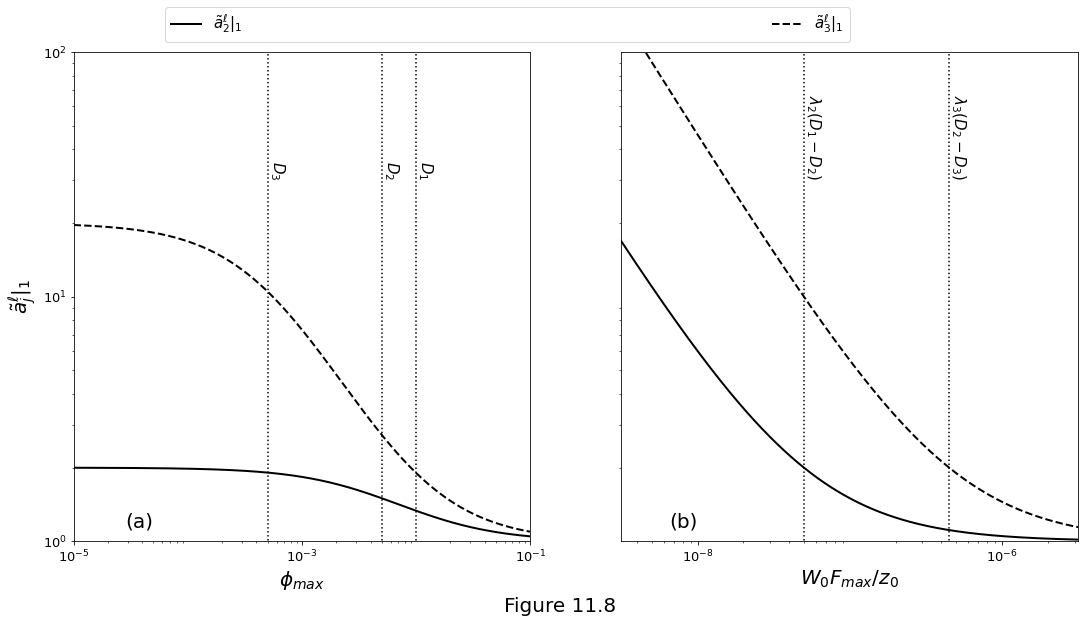

In [19]:
f, ax = plt.subplots(1, 2)
f.set_size_inches(18.0, 9.0)
f.set_facecolor('w')

p0, = ax[0].loglog(fmax, al2s, '-k', linewidth=2)
p1, = ax[0].loglog(fmax, al3s, '--k', linewidth=2)
for i, Di in enumerate(D):
    ax[0].plot([Di, Di], [1e-10, 1e10], ':k')
    ax[0].text(Di, 30., r"$D_{0}$".format(i+1), fontsize=15, rotation=-90, verticalalignment='bottom')
ax[0].set_ylim(1e0, 1e2)
ax[0].set_xlim(1e-5, 1e-1)
ax[0].set_xticks((1e-5, 1e-3, 1e-1))
ax[0].set_xlabel(r'$\phi_{max}$', fontsize=20)
ax[0].set_ylabel(r'$\tilde{a}_j^\ell\vert_1$', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].text(5e-5, 1.1e0, '(a)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')
plt.legend(handles=[p0, p1], labels=[r'$\tilde{a}_2^\ell\vert_1$', r'$\tilde{a}_3^\ell\vert_1$'], fontsize=15,
           bbox_to_anchor=(-1.0, 1.02, 1.5, .2),  loc='lower left', ncol=2, mode="expand", borderaxespad=0.)

ax[1].loglog(W0*Fmax/z0, al2f, '-k', W0*Fmax/z0, al3f, '--k', linewidth=2)
for (i, lmbdai), x in zip(enumerate(lmbda[1:]), D[0:-1] - D[1:]):
    ax[1].plot([lmbdai*x, lmbdai*x], [1e-10, 1e10], ':k')
    ax[1].text(lmbdai*x, 30., '$\lambda_{0}(D_{1}-D_{2})$'.format(i+2,i+1,i+2), 
               fontsize=15, rotation=-90, verticalalignment='bottom')
ax[1].set_ylim(1e0, 1e2)
ax[1].set_xlim(np.power(10, -8.5), np.power(10, -5.5))
ax[1].set_yticks(())
ax[1].set_xticks((1e-8, 1e-6))
ax[1].set_xlabel(r'$W_0 F_{max}/z_0$', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[1].text(1e-8, 1.1e0, '(b)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

f.supxlabel("Figure 11.8", fontsize=20)

plt.show()

### Variable transport rates

In steady-state, the secular equilibrium of the incoming mantle can be written as

$$
\begin{equation}
  \label{eq:col-activity}
  \effvel{j}\diff{\act\liq_j}{z} = -\act_j\liq \frac{W_0}{z_0}\Fmax
  \left(\frac{1-\dico_j}{\por + \omp\dico_j}\right) +
  \deco_j\left(\dicoratio_{j-1}\act_{j-1}\liq - \act_{j}\liq\right),
\end{equation}
$$

where we have used $\Gamma = \density W_0\Fmax/z_0$.

The batch-melting factor is given by

$$
\begin{equation}
  \label{eq:activity-decomposition}
  \act\liq_j = \left(\frac{\act\sol_j\vert_0}{\dico_j + (1-\dico_j)\Fmax z}\right)\inact\liq_j.
\end{equation}
$$

The simulation parameters are summarized below

Parameter | value | unit
--- | --- | ---
$z_0$ | 50 | km
$W_0$ | 5  | cm/yr
$\Fmax$ | 0.25 | ––
$\pormax$ | 0.005 | ––
$\velratio$ | 0.001 | ––
$\permexp$ | 2 | ––

In [20]:
class El:
    def __init__(self, d_=0.0086, l_=1.5e-10, a_=1.0):
        self.D = d_
        self.lambda_ = l_
        self.as0 = a_
        self.a = None
        self.ab = None


class Col:
    def __init__(self, z0_=50e3, w0_=0.05, vr_=1e-3, Fm_=0.25, fm_=0.0045, n_=2, Nz_=1000):
        self.z0 = z0_  # column height, metres
        self.W0 = w0_  # upwelling rate, metres per year
        self.vr = vr_  # W0/w0
        self.Fmax = Fm_  # Maximum degree of melting
        self.fmax = fm_  # Maximum porosity
        self.n = n_  # permeability exponent
        self.Nz = Nz_  # number of steps in z for output
        # column vectors (for plotting)
        self.z = np.linspace(0.0, 1.0, Nz_)  # height (non-dim)
        self.f = np.sqrt(0.25 * vr_ ** 2 + fm_ ** 2 * self.z) - 0.5 * vr_  # porosity
        self.F = Fm_ * self.z  # degree of melting


def derivatives(a, z, el, col, batch):
    ap = 0
    Dp = 1
    F = col.Fmax * z
    # f = col.fmax * np.power(z, 1 / col.n)
    f = np.sqrt(0.25*col.vr**2 + col.fmax**2 * z) - 0.5*col.vr
    dadz = np.zeros(len(el)).reshape(len(el))
    for i, (eli, ai) in enumerate(zip(el, a)):
        D = eli.D
        Dr = (f + (1 - f) * Dp) / (f + (1 - f) * D)
        wD = (D + (1 - D) * F) / (D + (1 - D) * f)
        L = eli.lambda_ * col.z0 / col.W0 / wD
        # melting and transport term
        melt = -ai * (1 - D) * col.Fmax / (D + (1 - D) * F)
        # ingrowth term
        ingrowth = L * (Dr * ap - ai)
        # compute full RHS
        if batch:
            ingrowth = 0
        dadz[i] = melt + ingrowth
        # update parent
        ap = ai
        Dp = D

    return dadz

def DecayChainColumnSolver(el, col):
    # assemble initial condition
    #  N.B. the governing equation is derived assuming
    #  that the solid is in secular equilibrium at the bottom
    #  of the column where \phi=0
    a0 = np.asarray([el[0].as0 / eli.D for eli in el])

    # solve ODEs
    # solve with melting/transport & ingrowth
    batch = False
    Sf = odeint(derivatives, a0, col.z, args=(el, col, batch), rtol=1e-5)
    for i, eli in enumerate(el):
        eli.a = Sf[:, i]
    # solve with melting/transport only
    batch = True
    St = odeint(derivatives, a0, col.z, args=(el, col, batch), rtol=1e-5)
    for i, eli in enumerate(el):
        eli.ab = St[:, i]

In [21]:
el = [El(0.0086, 1.5e-10, 1.0), El(0.0065, 9.19e-6, 1.0), El(0.0005, 4.33e-4)]
col = Col()
DecayChainColumnSolver(el, col)

Figure 11.9 below plot the numerical solution of equation $\eqref{eq:col-activity}$ for parameters from table above. __(a)__ Porosity from $\eqref{eq:meltcol-porosity-n2}$. __(b)__ The batch melting factor of equation $\eqref{eq:activity-decomposition}$ showing enrichment in the liquid due to the small partition coefficients. The dotted line has a value of $1/\Fmax$. __(c)__ The ingrowth factor of equation $\eqref{eq:activity-decomposition}$. __(d)__ The total activity. __(d)__ Parent-daughter activity ratios. In secular equilibrium, these ratios are unity (dotted line).

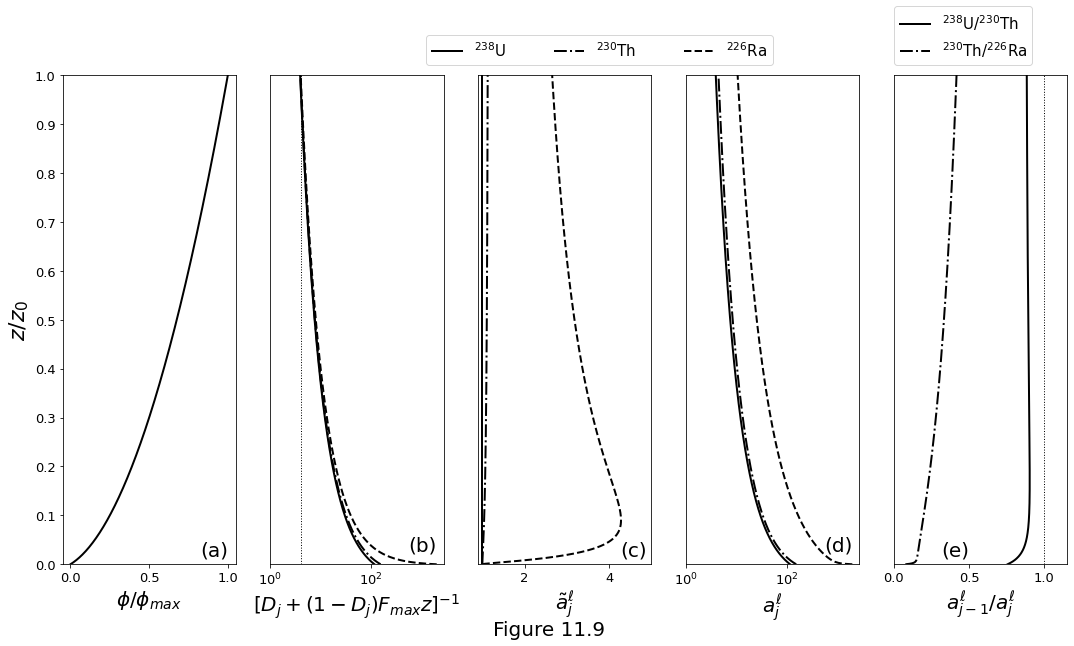

In [22]:
f, ax = plt.subplots(1, 5)
f.set_size_inches(18.0, 9.0)
f.set_facecolor('w')

lsty = ['-', '-.', '--']

ax[0].plot(col.f/col.f[-1], col.z,'-k', linewidth=2)
ax[0].set_ylabel(r'$z/z_0$', fontsize=22)
ax[0].set_xlabel(r'$\phi/\phi_{max}$', fontsize=20)
ax[0].set_ylim(0.0, 1.0)
ax[0].set_xticks((0.0, 0.5, 1.0))
ax[0].set_yticks(np.arange(0.0, 1.01, 0.1))
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].text(1.0, 0.01, '(a)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

for eli, lstyi in zip(el, lsty):
    ax[1].plot(eli.ab, col.z, 'k', linewidth=2, linestyle=lstyi)
ax[1].plot([1./col.Fmax, 1./col.Fmax], [0., 1.], ':k', linewidth=1)
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$[D_j + (1-D_j)F_{max}z]^{-1}$', fontsize=20)
ax[1].set_ylim(0.0, 1.0)
ax[1].set_xticks((1e0, 1e2))
ax[1].set_yticks(())
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[1].text(2e3, 0.02, '(b)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

for eli, lstyi in zip(el, lsty):
    ax[2].plot(eli.a/eli.ab, col.z, 'k', linewidth=2, linestyle=lstyi)
ax[2].set_yticks(())
ax[2].set_xlim(0.9, 5.0)
ax[2].set_ylim(0.0, 1.0)
ax[2].set_xlabel(r'$\tilde{a}_j^\ell$', fontsize=20)
ax[2].tick_params(axis='both', which='major', labelsize=13)
ax[2].text(4.9, 0.01, '(c)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')

p = [ax[3].semilogx(eli.a, col.z, 'k', linewidth=2, linestyle=lstyi) for eli, lstyi in zip(el, lsty)]
ax[3].set_xticks((1e0, 1e2))
ax[3].set_yticks(())
ax[3].set_ylim(0.0, 1.0)
ax[3].set_xlabel(r'$a^\ell_j$', fontsize=20)
ax[3].tick_params(axis='both', which='major', labelsize=13)
ax[3].text(2e3, 0.02, '(d)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')
ax[3].legend(handles=[p_[0] for p_ in p], labels=['$^{238}$U', r'$^{230}$Th', r'$^{226}$Ra'], fontsize=15,
             bbox_to_anchor=(-1.5, 1.02, 2.0, .2),  loc='lower left', ncol=3, mode="expand", borderaxespad=0.)


q = [ax[4].plot(elim.a/eli.a, col.z, 'k', linewidth=2, linestyle=lstyi) 
     for elim, eli, lstyi in zip(el[0:-1], el[1:], lsty[0:-1])]
ax[4].plot([1.0, 1.0], [0.0, 1.0], ':k', linewidth=1)
ax[4].set_xticks((0.0, 0.5, 1.0))
ax[4].set_yticks(())
ax[4].set_xlim(0.0, 1.15)
ax[4].set_ylim(0.0, 1.0)
ax[4].set_xlabel(r'${a}_{j-1}^\ell/{a}_{j}^\ell$', fontsize=20)
ax[4].tick_params(axis='both', which='major', labelsize=13)
ax[4].text(0.5, 0.01, '(e)', fontsize=20, verticalalignment='bottom', horizontalalignment='right')
ax[4].legend(handles=[q_[0] for q_ in q], labels=[r'$^{238}$U$/^{230}$Th', r'$^{230}$Th$/^{226}$Ra'], fontsize=15,
             bbox_to_anchor=(0.0, 1.02, 0.8, .2),  loc='lower left', ncol=1, mode="expand", borderaxespad=0.)

f.supxlabel("Figure 11.9", fontsize=20)

plt.show()

In [23]:
class ColTop:
    def __init__(self, N):
        self.a = np.zeros(N*N).reshape(N, N)
        self.ab = np.zeros(N*N).reshape(N, N)

In [24]:
el = [El(0.0086, 1.5e-10, 1.0), El(0.0065, 9.19e-6, 1.0), El(0.0005, 4.33e-4)]
col = Col()
DecayChainColumnSolver(el, col)
col.Nz = 10
    
span_fmax = np.log10([1e-4, 0.25])  # porosity
span_W0   = np.log10([1e-3, 1])  # m/yr

Nfmax = 30
NW0   = 30
N = Nfmax*NW0

fmax = np.logspace(span_fmax[0], span_fmax[1], Nfmax)
W0   = np.logspace(span_W0[0], span_W0[1], NW0)

coltop = [ColTop(NW0), ColTop(NW0), ColTop(NW0)]

for j, fmaxj in enumerate(fmax):  # j=1:length(fmax)
    for i, W0i in enumerate(W0):  # =1:length(W0)
        col.W0 = W0i
        col.fmax = fmaxj
        DecayChainColumnSolver(el, col)
        for elk, coltopk in zip(el, coltop):
            coltopk.a[i, j] = elk.a[-1]
            coltopk.ab[i, j] = elk.ab[-1]

Figure 11.10 below plot the parameter space diagrams for the column-top daughter-parent activity ratios. Lines are activity-ratio isopleths. Stars represent column-top values from the column shown in Figure above. __(a)__ $\isotp{230}{Th}/\isotp{238}{U}$. __(b)__ $\isotp{226}{Ra}/\isotp{230}{Th}$.

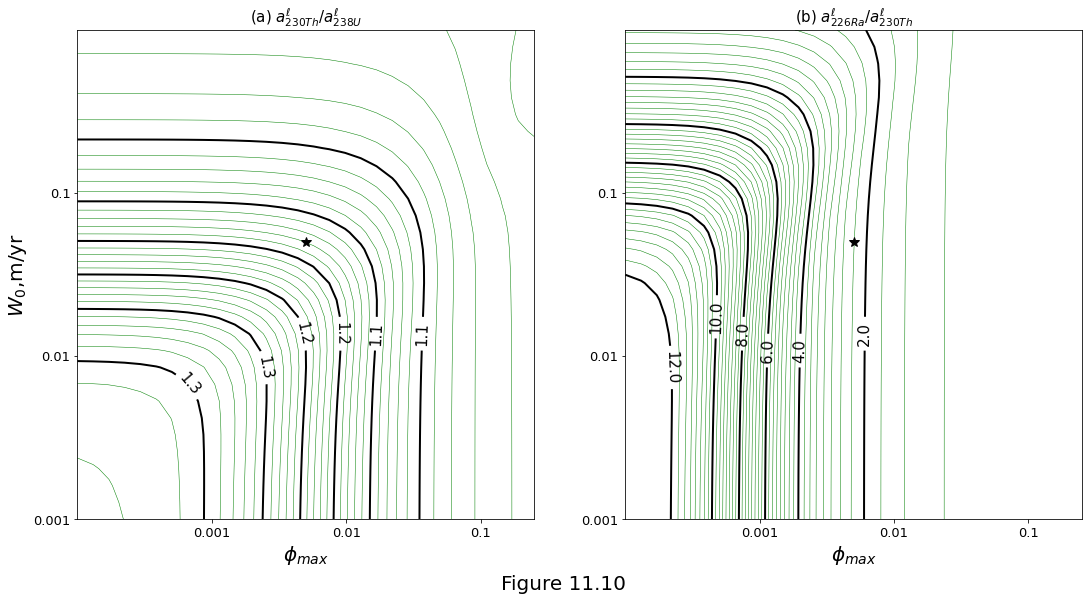

In [25]:
f, ax = plt.subplots(1, 2)
f.set_size_inches(18.0, 9.0)
f.set_facecolor('w')
    
actratio = coltop[1].a / coltop[0].a
cvec = np.arange(1.0, 2.005, 0.01)
cvec = np.setdiff1d(cvec, cvec[5:-1:5])
cs = ax[0].contour(np.log10(fmax), np.log10(W0), actratio, cvec, colors='g', linewidths=0.5)
cvec = np.arange(1.05, 2.01, 0.05)
cs = ax[0].contour(np.log10(fmax), np.log10(W0), actratio, cvec, colors='k', linewidths=2)
ax[0].clabel(cs, inline=1, fontsize=15, fmt="%1.1f")
ax[0].plot(np.log10(0.005), np.log10(0.05), '*k', markersize=10)
ax[0].set_xticks([-3.0, -2.0, -1.0])
ax[0].set_xticklabels([1e-3, 1e-2, 1e-1])
ax[0].set_yticks([-3.0, -2.0, -1.0])
ax[0].set_yticklabels([1e-3, 1e-2, 1e-1])
ax[0].set_xlabel(r'$\phi_{max}$', fontsize=20)
ax[0].set_ylabel(r'$W_0$,m/yr', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].set_title(r'(a) $a^\ell_{230Th}/a^\ell_{238U}$', fontsize=15)

actratio = coltop[2].a / coltop[1].a
cvec = np.arange(1.0, 12.1, 0.25)
cvec = np.setdiff1d(cvec, cvec[4::8])
cs = ax[1].contour(np.log10(fmax), np.log10(W0), actratio, cvec, colors='g', linewidths=0.5)
cvec = np.arange(2.0, 12.1, 2.0)
cs = ax[1].contour(np.log10(fmax), np.log10(W0), actratio, cvec, colors='k', linewidths=2)
ax[1].clabel(cs, inline=1, fontsize=15, fmt="%1.1f")
ax[1].plot(np.log10(0.005), np.log10(0.05), '*k', markersize=10)
ax[1].set_xticks([-3.0, -2.0, -1.0])
ax[1].set_xticklabels([1e-3, 1e-2, 1e-1])
ax[1].set_yticks([-3.0, -2.0, -1.0])
ax[1].set_yticklabels([1e-3, 1e-2, 1e-1])
ax[1].set_xlabel(r'$\phi_{max}$', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[1].set_title(r'(b) $a^\ell_{226Ra}/a^\ell_{230Th}$', fontsize=15)

f.supxlabel("Figure 11.10", fontsize=20)

plt.show()